In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset5/CLAN_data.csv


NLP_TASK-2_Assignment

In [5]:
!pip install evaluate
!pip install rouge_score
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=297bd5ddc06c07fd3026b3570a7b730063fa937999aeb0581243a8d891e35a63
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00


In [7]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader

# Hugging Face libraries (only for model and tokenization)
from transformers import BartForConditionalGeneration, BartTokenizer, T5ForConditionalGeneration, T5Tokenizer, AdamW
from datasets import Dataset, DatasetDict


# Evaluation metrics (using the `evaluate` library)
import evaluate

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [8]:
EXPANSION_MAP = {
    "aren't": "are not",
    "can't": "can not",
    "could've": "could have",
    "couldn't": "could not",
    "d.c": "district of columbia",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "everyone's": "everyone is",
    "feb": "february",
    "gonna": "going to",
    "gov": "governor",
    "hasn't": "has not",
    "haven't": "have not",
    "he's": "he is",
    "here's": "here is",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "i.e": "id est",
    "isn't": "is not",
    "it'll": "it will",
    "it's": "it is",
    "kinda": "kind of",
    "let's": "let us",
    "life's": "life is",
    "p.m": "post meridiem",
    "she'll": "she will",
    "she's": "she is",
    "shouldn't": "should not",
    "somebody's": "somebody is",
    "that's": "that is",
    "there'll": "there will",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "today's": "today is",
    "u.k": "united kingdom",
    "u.s": "united states",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "where's": "where is",
    "who's": "who is",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "y'all": "you all",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

def expand_text(text):
    for short_form, full_form in EXPANSION_MAP.items():
        text = re.sub(r'\b' + re.escape(short_form) + r'\b', full_form, text, flags=re.IGNORECASE)
    return text

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # for hindi words
    text = re.sub(r'[^\u0900-\u097Fa-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    processed_words = []
    for word in words:
        if re.fullmatch(r'[a-zA-Z]+', word):
            processed_words.append(word.lower())
        else:
            processed_words.append(word)
    text = ' '.join(processed_words)
    return text

def preprocess_text(text):
    text = expand_text(text)
    text = clean_text(text)
    return text

df = pd.read_csv('/kaggle/input/dataset5/CLAN_data.csv')
print("Dataset shape:", df.shape)
df.head()

df['post_clean'] = df["Social Media Post"].apply(preprocess_text)
df['claim_clean'] = df["Normalized Claim"].apply(preprocess_text)
print(df["post_clean"])
print(df["claim_clean"])

df[['post_clean', 'claim_clean']].to_csv('post_claim_clean.csv', index=False)
df[['post_clean', 'claim_clean']].to_json('post_claim_clean.json', orient='records', lines=True)


Dataset shape: (2811, 3)
0       president realdonaldtrump bidens plan would me...
1       important announcement coronavirus last evenin...
2                              heart is delighted to hear
3       an allowed appeal is one where the initial ref...
4       warm water therapy dr d mensah asare says that...
                              ...                        
2806    kamala harris failed the bar st time amy coney...
2807    we warned you illegals can now become police o...
2808    four weeks ago all uk primary aged children ge...
2809    there is nothing wrong with asking why swing s...
2810    one of the worst days so far for coronavirus w...
Name: post_clean, Length: 2811, dtype: object
0       bidens energy plan would get rid of seniors ai...
1       if someone with the new coronavirus sneezes it...
2                              heart is delighted to hear
3       the vast majority of people coming across the ...
4       a widely popular social media post claims that...
 

In [9]:
dataset = Dataset.from_pandas(df[['post_clean', 'claim_clean']])
train_testvalid = dataset.train_test_split(test_size=0.3, seed=seed)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=seed)

data_dict = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})


In [10]:
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
t5_tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-base')
def bart_preprocess_function(examples):
    inputs = examples['post_clean']
    targets = examples['claim_clean']
    model_inputs = bart_tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding="max_length"
    )

    labels = bart_tokenizer(
        targets,
        max_length=128,
        truncation=True,
        padding="max_length"
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
def t5_preprocess_function(examples):
    inputs = ["normalize: " + txt for txt in examples['post_clean']]
    targets = examples['claim_clean']
    model_inputs = t5_tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding="max_length"
    )
    labels = t5_tokenizer(
        targets,
        max_length=128,
        truncation=True,
        padding="max_length"
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
data_dict_bart = data_dict.map(
    bart_preprocess_function,
    batched=True,
    remove_columns=["post_clean", "claim_clean"]  # critical fix
)
data_dict_t5 = data_dict.map(
    t5_preprocess_function,
    batched=True,
    remove_columns=["post_clean", "claim_clean"]
)
print("BART train columns:", data_dict_bart['train'].column_names)
print("T5 train columns:", data_dict_t5['train'].column_names)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/1967 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/1967 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

BART train columns: ['input_ids', 'attention_mask', 'labels']
T5 train columns: ['input_ids', 'attention_mask', 'labels']


In [11]:
def collate_fn(features):
    batch = {
        key: torch.tensor([f[key] for f in features])
        for key in features[0]
    }
    if "labels" in batch:
        batch["labels"][batch["labels"] == bart_tokenizer.pad_token_id] = -100
    return batch

In [12]:
train_loader_bart = DataLoader(data_dict_bart["train"], batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader_bart = DataLoader(data_dict_bart["validation"], batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader_bart = DataLoader(data_dict_bart["test"], batch_size=1, shuffle=False, collate_fn=collate_fn)


In [13]:
train_loader_t5 = DataLoader(data_dict_t5["train"], batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader_t5 = DataLoader(data_dict_t5["validation"], batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader_t5 = DataLoader(data_dict_t5["test"], batch_size=1, shuffle=False, collate_fn=collate_fn)

This is for BART training

Epoch 1/5
Losses->Train: 3.0979, Val: 2.5585

Epoch 2/5
Losses->Train: 2.5092, Val: 2.4120

Epoch 3/5
Losses->Train: 2.1899, Val: 2.4037

Epoch 4/5
Losses->Train: 1.8938, Val: 2.4058

Epoch 5/5
Losses->Train: 1.6577, Val: 2.3828


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics score->
ROUGE: {'rouge1': 0.33927986341833827, 'rouge2': 0.21499669651082462, 'rougeL': 0.31792184156383896, 'rougeLsum': 0.31580756142137156}
BLEU: 0.1986
BERTScore F1: 0.8783
bart Model saved.


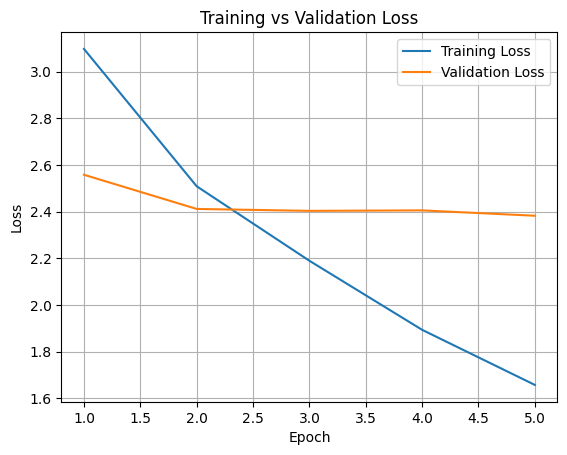

In [16]:
from transformers import BartForConditionalGeneration, BartTokenizer, AdamW
import evaluate
import numpy as np
import matplotlib.pyplot as plt

rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-base').to(device)
optimizer_bart = AdamW(bart_model.parameters(), lr=2e-5)
num_epochs = 5
best_val_loss_bart = float("inf")

train_losses = []
val_losses = []

def generate_predictions(model, tokenizer, loader):
    model.eval()
    preds, refs = [], []
    with torch.no_grad():
        for batch in loader:
            inputs = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            outputs = model.generate(input_ids=inputs, attention_mask=mask, max_length=128, num_beams=4)
            preds.append(tokenizer.decode(outputs[0], skip_special_tokens=True))

            labels = batch["labels"][0]
            labels[labels == -100] = tokenizer.pad_token_id
            refs.append(tokenizer.decode(labels, skip_special_tokens=True))
    return preds, refs

print("This is for BART training")
for epoch in range(num_epochs):
    bart_model.train()
    train_loss = 0.0
    for batch in train_loader_bart:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer_bart.zero_grad()
        loss = bart_model(**batch).loss
        loss.backward()
        optimizer_bart.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader_bart)
    train_losses.append(avg_train_loss)

    bart_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader_bart:
            batch = {k: v.to(device) for k, v in batch.items()}
            val_loss += bart_model(**batch).loss.item()
    avg_val_loss = val_loss / len(val_loader_bart)
    val_losses.append(avg_val_loss)
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Losses->Train: {avg_train_loss:.4f}, Val: {avg_val_loss:.4f}")

val_preds, val_refs = generate_predictions(bart_model, bart_tokenizer, val_loader_bart)
rouge_result = rouge.compute(predictions=val_preds, references=val_refs)
bleu_result = bleu.compute(predictions=val_preds, references=val_refs)
bert_result = bertscore.compute(predictions=val_preds, references=val_refs, lang="en")

formatted_rouge = {
    'rouge1': np.float64(rouge_result["rouge1"]),
    'rouge2': np.float64(rouge_result["rouge2"]),
    'rougeL': np.float64(rouge_result["rougeL"]),
    'rougeLsum': np.float64(rouge_result["rougeLsum"]),
}
bleu_score = round(bleu_result["bleu"], 4)
bert_f1 = round(np.mean(bert_result["f1"]), 4)

print("Metrics score->")
print("ROUGE:", formatted_rouge)
print("BLEU:", bleu_score)
print("BERTScore F1:", bert_f1)


torch.save(bart_model.state_dict(), "best_bart_model.pt")
print("bart Model saved.")

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5 training


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.



Epoch 1/5
Losses -->Train: 6.5277, Val: 0.5797

Epoch 2/5
Losses -->Train: 0.6006, Val: 0.4742

Epoch 3/5
Losses -->Train: 0.5100, Val: 0.4388

Epoch 4/5
Losses -->Train: 0.4722, Val: 0.4176

Epoch 5/5
Losses -->Train: 0.4480, Val: 0.4070


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Metrics-->
ROUGE: {'rouge1': 0.25086252657816405, 'rouge2': 0.15908467351056593, 'rougeL': 0.2316540421233204, 'rougeLsum': 0.2314983753378036}
BLEU: 0.0781
BERTScore F1: 0.8526
T5 model saved.


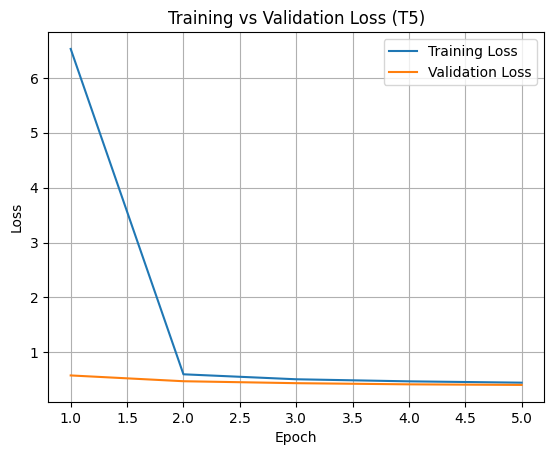

In [17]:
from transformers import AdamW
import evaluate
import numpy as np
import matplotlib.pyplot as plt

rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

t5_model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-base').to(device)
optimizer_t5 = AdamW(t5_model.parameters(), lr=2e-5)
best_val_loss_t5 = float("inf")

train_losses = []
val_losses = []

def generate_predictions(model, tokenizer, loader):
    model.eval()
    preds = []
    refs = []
    with torch.no_grad():
        for batch in loader:
            inputs = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            outputs = model.generate(input_ids=inputs, attention_mask=mask, max_length=128, num_beams=4)
            preds.append(tokenizer.decode(outputs[0], skip_special_tokens=True))

            labels = batch["labels"][0]
            labels[labels == -100] = tokenizer.pad_token_id
            refs.append(tokenizer.decode(labels, skip_special_tokens=True))
    return preds, refs

print("T5 training")
for epoch in range(num_epochs):
    t5_model.train()
    train_loss = 0.0
    for batch in train_loader_t5:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer_t5.zero_grad()
        loss = t5_model(**batch).loss
        loss.backward()
        optimizer_t5.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader_t5)
    train_losses.append(avg_train_loss)

    t5_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader_t5:
            batch = {k: v.to(device) for k, v in batch.items()}
            val_loss += t5_model(**batch).loss.item()
    avg_val_loss = val_loss / len(val_loader_t5)
    val_losses.append(avg_val_loss)
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Losses -->Train: {avg_train_loss:.4f}, Val: {avg_val_loss:.4f}")

val_preds, val_refs = generate_predictions(t5_model, t5_tokenizer, val_loader_t5)
rouge_result = rouge.compute(predictions=val_preds, references=val_refs)
bleu_result = bleu.compute(predictions=val_preds, references=val_refs)
bert_result = bertscore.compute(predictions=val_preds, references=val_refs, lang="en")

formatted_rouge = {
    'rouge1': np.float64(rouge_result["rouge1"]),
    'rouge2': np.float64(rouge_result["rouge2"]),
    'rougeL': np.float64(rouge_result["rougeL"]),
    'rougeLsum': np.float64(rouge_result["rougeLsum"]),
}
bleu_score = round(bleu_result["bleu"], 4)
bert_f1 = round(np.mean(bert_result["f1"]), 4)

print("Evaluation Metrics-->")
print("ROUGE:", formatted_rouge)
print("BLEU:", bleu_score)
print("BERTScore F1:", bert_f1)


torch.save(t5_model.state_dict(), "best_t5_model.pt")
print("T5 model saved.")

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (T5)')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
from transformers import BartTokenizer, BartForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration
from datasets import Dataset
from torch.utils.data import DataLoader
import torch
import evaluate
import numpy as np

def evaluate_on_demo_test(file_path, model_name="bart", model_weights_path=None):
    assert model_name in ["bart", "t5"], "model_name must be either 'bart' or 't5'"

    # Load and preprocess CSV
    df_test = pd.read_csv(file_path)
    df_test['post_clean'] = df_test["Social Media Post"].apply(preprocess_text)
    df_test['claim_clean'] = df_test["Normalized Claim"].apply(preprocess_text)
    dataset = Dataset.from_pandas(df_test[['post_clean', 'claim_clean']])

    # Tokenizer and model selection
    if model_name == "bart":
        tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
        def preprocess(example):
            inputs = tokenizer(
                example['post_clean'],
                max_length=512,
                truncation=True,
                padding="max_length"
            )
            labels = tokenizer(
                example['claim_clean'],
                max_length=128,
                truncation=True,
                padding="max_length"
            )
            inputs["labels"] = labels["input_ids"]
            return inputs
    else:
        tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-base')
        model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-base')
        def preprocess(example):
            inputs = ["normalize: " + txt for txt in example['post_clean']]
            targets = example['claim_clean']
            model_inputs = tokenizer(
                inputs,
                max_length=512,
                truncation=True,
                padding="max_length"
            )
            labels = tokenizer(
                targets,
                max_length=128,
                truncation=True,
                padding="max_length"
            )
            model_inputs["labels"] = labels["input_ids"]
            return model_inputs

    # Load weights if provided
    if model_weights_path:
        model.load_state_dict(torch.load(model_weights_path, map_location=device))
    model.to(device)
    model.eval()

    # Preprocess dataset
    test_dataset = dataset.map(preprocess, batched=True, remove_columns=["post_clean", "claim_clean"])

    def collate_fn(features):
        batch = {
            key: torch.tensor([f[key] for f in features])
            for key in features[0]
        }
        if "labels" in batch:
            batch["labels"][batch["labels"] == tokenizer.pad_token_id] = -100
        return batch

    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # Inference
    preds, refs = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            output_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128, num_beams=4)
            decoded_output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            preds.append(decoded_output)

            labels = batch["labels"][0]
            labels[labels == -100] = tokenizer.pad_token_id
            decoded_label = tokenizer.decode(labels, skip_special_tokens=True)
            refs.append(decoded_label)

    # Metrics
    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    bertscore = evaluate.load("bertscore")

    rouge_result = rouge.compute(predictions=preds, references=refs)
    bleu_result = bleu.compute(predictions=preds, references=refs)
    bert_result = bertscore.compute(predictions=preds, references=refs, lang="en")

    formatted_rouge = {
        'rouge1': np.float64(rouge_result["rouge1"]),
        'rouge2': np.float64(rouge_result["rouge2"]),
        'rougeL': np.float64(rouge_result["rougeL"]),
        'rougeLsum': np.float64(rouge_result["rougeLsum"]),
    }
    bleu_score = round(bleu_result["bleu"], 4)
    bert_f1 = round(np.mean(bert_result["f1"]), 4)

    print(f"\n{model_name.upper()} Evaluation Results:")
    print("ROUGE:", formatted_rouge)
    print("BLEU:", bleu_score)
    print("BERTScore F1:", bert_f1)

    return preds, refs


In [22]:
# Evaluate BART model
evaluate_on_demo_test('/kaggle/input/dataset5/CLAN_data.csv', model_name="bart", model_weights_path="best_bart_model.pt")

<ipython-input-21-abe71f605b21>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path, map_location=device))


Map:   0%|          | 0/2811 [00:00<?, ? examples/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BART Evaluation Results:
ROUGE: {'rouge1': 0.4219893436767118, 'rouge2': 0.30483018745681395, 'rougeL': 0.3994064791272429, 'rougeLsum': 0.39957922808220414}
BLEU: 0.2885
BERTScore F1: 0.8908


(['president realdonald trump bidens plan would mean americas seniors have no air conditioningers during the summer',
  'drinking warm water is effective for all viruses try not to drink liquids with ice',
  'heart is delighted to hear',
  'an allowed appeal is one where the initial refusal is overturned and the judge replaces the decision most commonly with a decision to grant a form of status',
  'a social media post claims that drinking warm water can cure a number of diseases we factchecked and found that the claim is mostly false',
  'thyrocare lab sealed by governor because they gave fake covid positive reports to ppl',
  'a covid patient was nearly buried alive',
  'eating onions daily helps increase immunity treat depression fight the common cold and flu being a potent natural antibiotic and it helps you sleep better',
  'the shooting at an elementary school in uvalde texas was a false flag',
  'in asia where hundreds of millions of smallpox vaccinations were given from to aids

In [ ]:
# Evaluate T5 model
evaluate_on_demo_test('/kaggle/input/dataset5/CLAN_data.csv', model_name="t5", model_weights_path="best_t5_model.pt")

<ipython-input-21-abe71f605b21>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path, map_location=device))


Map:   0%|          | 0/2811 [00:00<?, ? examples/s]

In [ ]:
# evaluate_on_demo_test("demo_test.csv", "t5")